In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print(f"Memory growth error: {e}")

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D,Flatten,InputLayer,AveragePooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization,Dropout,Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, InceptionV3, ResNet50,MobileNetV2, VGG19, EfficientNetB7, EfficientNetB0
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score, recall_score
from keras.mixed_precision import set_global_policy
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet_v2 import preprocess_input
import pickle

**Data Frame Collection**

In [22]:
path = "D:/Github/Datasets/combined_indian_dataset"

labels = os.listdir(path)
df = pd.DataFrame(columns=['img_path','label'])

for label in labels:
    img_dir_path = os.path.join(path,label)
    for img in os.listdir(img_dir_path):
        img_path = os.path.join(img_dir_path,img)
        df.loc[df.shape[0]] = [img_path,label]
        
# shuffling dataset
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.to_csv('more_dataset.csv')

In [4]:
df = pd.read_csv('more_dataset.csv')
print(df.shape)
print(df.shape[0])

(7531, 3)
7531


In [5]:
df.head()

,Unnamed: 0,img_path,label
0,0,D:/Github/Datasets/combined_indian_dataset\dou...,double_ka_meetha
1,1,D:/Github/Datasets/combined_indian_dataset\ome...,omelette
2,2,D:/Github/Datasets/combined_indian_dataset\kof...,kofta
3,3,D:/Github/Datasets/combined_indian_dataset\ghe...,ghevar
4,4,D:/Github/Datasets/combined_indian_dataset\poh...,poha


In [6]:
print("Number of Images: ",df.shape[0])
print("Number of labels: ",df['label'].nunique())

print('There are 100+ images per class')

Number of Images:  7531
Number of labels:  73
There are 100+ images per class


In [7]:
path = "D:/Github/Datasets/combined_indian_dataset"

for label in os.listdir(path):
    img_dir_path = os.path.join(path,label)
    print(label, len(os.listdir(img_dir_path)))

adhirasam 101
aloo_shimla_mirch 100
aloo_tikki 100
anarsa 100
baklava 110
bandar_laddu 100
basundi 100
bhatura 100
bhindi_masala 101
biryani 101
burger 100
butter_chicken 100
butter_naan 100
chai 100
chana_masala 101
chapati 100
chicken_razala 92
chicken_tikka 102
chicken_wings 110
chikki 100
chocolate_cake 110
chocolate_mousse 110
chole_bhature 100
cupcakes 110
dal_makhani 100
dal_tadka 100
donuts 110
double_ka_meetha 100
french_fries 110
fried_rice 100
gajar_ka_halwa 104
garlic_bread 110
gavvalu 89
ghevar 110
gulab_jamun 100
ice_cream 110
idli 100
imarti 109
jalebi 100
kaathi_rolls 100
kachori 103
kajjikaya 114
kakinada_khaja 103
kalakand 106
kofta 102
kulfi 100
kuzhi_paniyaram 107
lassi 114
lyangcha 96
mac_and_cheese 110
malapua 102
masala_dosa 100
misti_doi 96
modak 111
momos 100
mysore_pak 107
naan 112
omelette 110
paani_puri 85
pakode 100
palak_paneer 105
paneer_butter_masala 101
pav_bhaji 100
pizza 100
poha 101
rasgulla 108
samosa 100
sheera 100
sheer_korma 100
spring_rolls 110


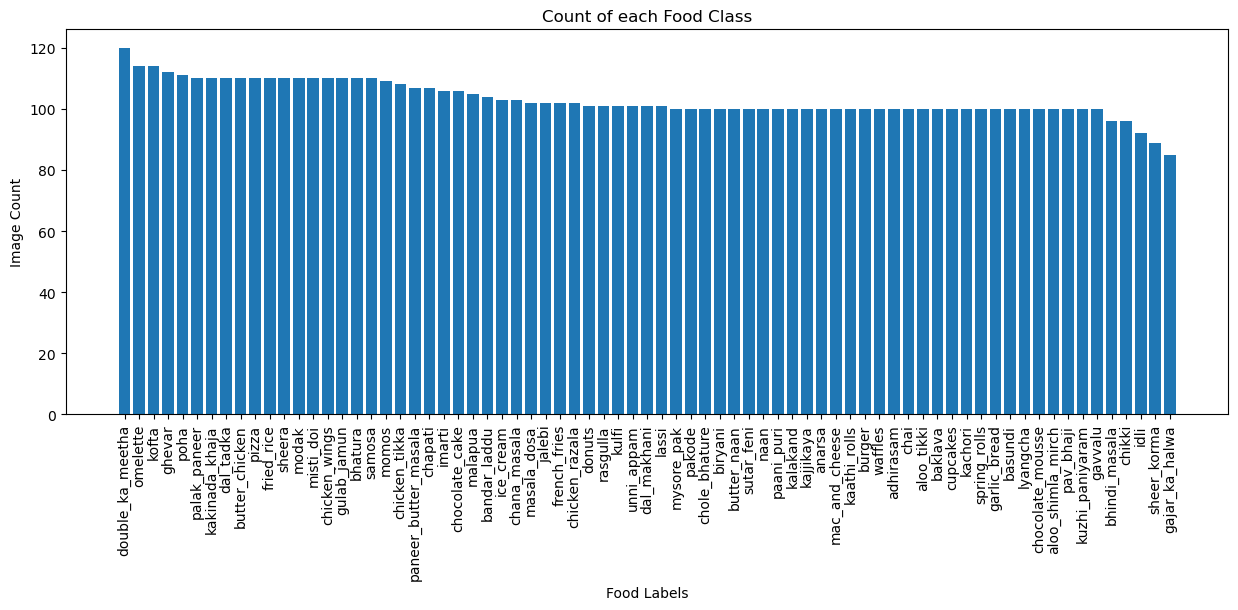

In [8]:
plt.figure(figsize=(15,5))
plt.bar(x = df['label'].unique(), height = df['label'].value_counts())
plt.xlabel("Food Labels")
plt.ylabel("Image Count")
plt.xticks(rotation=90)
plt.title("Count of each Food Class")
plt.show()

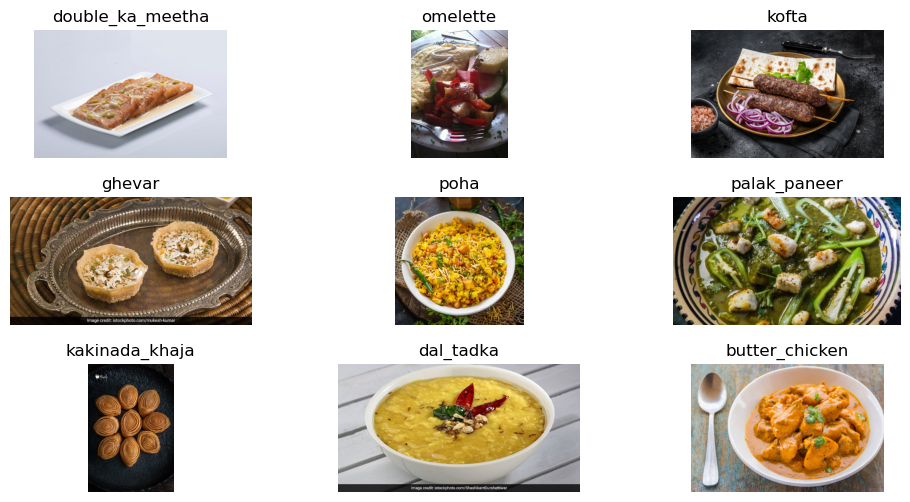

In [9]:
plt.figure(figsize=(12,6))

for i in range(1,4):
    for j in range(1,4):
        plt.subplot(3,3,3*(i-1) + j)
        img_data = cv2.imread(df['img_path'][3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(df['label'][3*(i-1) + (j-1)])
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

**TRAIN TEST SPLIT**

In [10]:
x_train, x_val, y_train, y_val = train_test_split(df['img_path'], df['label'], random_state = 42, test_size = 0.2)
print(x_train.shape)
print(x_val.shape)

(6024,)
(1507,)


**Preprocess and Augmentation**

In [11]:
def preprocess(img_paths):
    images = []
    for img_path in img_paths:
        img_data = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(img_rgb, (224, 224))
        image_normalized = image_resized.astype('float32') / 255
        images.append(image_normalized)

    return np.array(images)

In [12]:
#augmention
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2, #horizontal shift
    height_shift_range=0.2, #vertical shift
    shear_range=0.2,
    zoom_range=0.2, #random zoom
    horizontal_flip=True, #random horizontal flips
    fill_mode='nearest' 
)
datagen_val = ImageDataGenerator(
    rescale=1./255 
)

In [13]:
train_dataset = datagen_train.flow_from_dataframe(
    dataframe=pd.DataFrame({'img_path':x_train,'label':y_train}),
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=True,
    seed=42 
)

validation_dataset = datagen_val.flow_from_dataframe(
    dataframe=pd.DataFrame({'img_path':x_val,'label':y_val}),
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=True,
    seed=42 
)

Found 6023 validated image filenames belonging to 73 classes.
Found 1507 validated image filenames belonging to 73 classes.


d:\Anaconda\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [14]:
# Check for invalid image paths
invalid_images = []
for img_path in df['img_path']:
    if not os.path.isfile(img_path):
        invalid_images.append(img_path)

print("Invalid image paths:", invalid_images)

Invalid image paths: []


In [15]:
class_indices = train_dataset.class_indices

# Print the class indices dictionary
print("Class Indices:")
print(class_indices)

Class Indices:
{'adhirasam': 0, 'aloo_shimla_mirch': 1, 'aloo_tikki': 2, 'anarsa': 3, 'baklava': 4, 'bandar_laddu': 5, 'basundi': 6, 'bhatura': 7, 'bhindi_masala': 8, 'biryani': 9, 'burger': 10, 'butter_chicken': 11, 'butter_naan': 12, 'chai': 13, 'chana_masala': 14, 'chapati': 15, 'chicken_razala': 16, 'chicken_tikka': 17, 'chicken_wings': 18, 'chikki': 19, 'chocolate_cake': 20, 'chocolate_mousse': 21, 'chole_bhature': 22, 'cupcakes': 23, 'dal_makhani': 24, 'dal_tadka': 25, 'donuts': 26, 'double_ka_meetha': 27, 'french_fries': 28, 'fried_rice': 29, 'gajar_ka_halwa': 30, 'garlic_bread': 31, 'gavvalu': 32, 'ghevar': 33, 'gulab_jamun': 34, 'ice_cream': 35, 'idli': 36, 'imarti': 37, 'jalebi': 38, 'kaathi_rolls': 39, 'kachori': 40, 'kajjikaya': 41, 'kakinada_khaja': 42, 'kalakand': 43, 'kofta': 44, 'kulfi': 45, 'kuzhi_paniyaram': 46, 'lassi': 47, 'lyangcha': 48, 'mac_and_cheese': 49, 'malapua': 50, 'masala_dosa': 51, 'misti_doi': 52, 'modak': 53, 'momos': 54, 'mysore_pak': 55, 'naan': 56, 

**Index to class dictionary**

In [16]:
index_to_class = {v: k for k, v in class_indices.items()}
print("Index to Class Mapping:")
print(index_to_class)

Index to Class Mapping:
{0: 'adhirasam', 1: 'aloo_shimla_mirch', 2: 'aloo_tikki', 3: 'anarsa', 4: 'baklava', 5: 'bandar_laddu', 6: 'basundi', 7: 'bhatura', 8: 'bhindi_masala', 9: 'biryani', 10: 'burger', 11: 'butter_chicken', 12: 'butter_naan', 13: 'chai', 14: 'chana_masala', 15: 'chapati', 16: 'chicken_razala', 17: 'chicken_tikka', 18: 'chicken_wings', 19: 'chikki', 20: 'chocolate_cake', 21: 'chocolate_mousse', 22: 'chole_bhature', 23: 'cupcakes', 24: 'dal_makhani', 25: 'dal_tadka', 26: 'donuts', 27: 'double_ka_meetha', 28: 'french_fries', 29: 'fried_rice', 30: 'gajar_ka_halwa', 31: 'garlic_bread', 32: 'gavvalu', 33: 'ghevar', 34: 'gulab_jamun', 35: 'ice_cream', 36: 'idli', 37: 'imarti', 38: 'jalebi', 39: 'kaathi_rolls', 40: 'kachori', 41: 'kajjikaya', 42: 'kakinada_khaja', 43: 'kalakand', 44: 'kofta', 45: 'kulfi', 46: 'kuzhi_paniyaram', 47: 'lassi', 48: 'lyangcha', 49: 'mac_and_cheese', 50: 'malapua', 51: 'masala_dosa', 52: 'misti_doi', 53: 'modak', 54: 'momos', 55: 'mysore_pak', 56:

**Model Training**

In [17]:
def build_model(base):
    base_model = base
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        
        Dense(512, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),

        Dense(256, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(73, activation='softmax'),  # For binary classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU:", gpus)
else:
    print("Using CPU")

Num GPUs Available:  1
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Transfer Learning with various Pretrained Models**

**1. MobileNetV2**

In [40]:
mobilenet_model = build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
mobilenet_model.summary()
history_mobilenet = mobilenet_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               32113152  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 256)              

**2. InceptionV3**

In [41]:
inception_model = build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
inception_model.summary()
history_inception = inception_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               26214912  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_100 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                      

**3. ResNet50**

In [19]:
resnet50_model = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
resnet50_model.summary()
history_resnet = resnet50_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

KeyboardInterrupt: 

**4. EfficientNetB0**

In [20]:
efficientNetB0_model = build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientNetB0_model.summary()
history_ENB0 = efficientNetB0_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               32113152  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                      

**Analysis**

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2')
plt.plot(history_inception.history['loss'], label='Inception')
# plt.plot(history_resnet.history['loss'], label='ResNet')
plt.plot(history_ENB0.history['loss'], label='EfficientNetB0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2')
plt.plot(history_inception.history['accuracy'], label='Inception')
# plt.plot(history_resnet.history['accuracy'], label='ResNet')
plt.plot(history_ENB0.history['accuracy'], label='EfficientNetB0')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Clearly this isn't working even with a larger dataset so were gonna change some hyperparameters from here.

In [25]:
#augmention
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2, #horizontal shift
    height_shift_range=0.2, #vertical shift
    shear_range=0.2,
    zoom_range=0.2, #random zoom
    horizontal_flip=True, #random horizontal flips
    fill_mode='nearest' 
)
datagen_val = ImageDataGenerator(
    rescale=1./255 
)

In [30]:
train_dataset = datagen_train.flow_from_dataframe(
    dataframe=pd.DataFrame({'img_path':x_train,'label':y_train}),
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=16,
    class_mode='categorical', 
    shuffle=True,
    seed=42,
    cache=True,
    buffer_size=1000
)

validation_dataset = datagen_val.flow_from_dataframe(
    dataframe=pd.DataFrame({'img_path':x_val,'label':y_val}),
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=16,
    class_mode='categorical', 
    shuffle=True,
    seed=42,
    cache=True,
    buffer_size=1000
)

Found 6023 validated image filenames belonging to 73 classes.
Found 1507 validated image filenames belonging to 73 classes.


d:\Anaconda\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [27]:
class_indices = train_dataset.class_indices

# Print the class indices dictionary
print("Class Indices:")
print(class_indices)

index_to_class = {v: k for k, v in class_indices.items()}
print("Index to Class Mapping:")
print(index_to_class)

Class Indices:
{'adhirasam': 0, 'aloo_shimla_mirch': 1, 'aloo_tikki': 2, 'anarsa': 3, 'baklava': 4, 'bandar_laddu': 5, 'basundi': 6, 'bhatura': 7, 'bhindi_masala': 8, 'biryani': 9, 'burger': 10, 'butter_chicken': 11, 'butter_naan': 12, 'chai': 13, 'chana_masala': 14, 'chapati': 15, 'chicken_razala': 16, 'chicken_tikka': 17, 'chicken_wings': 18, 'chikki': 19, 'chocolate_cake': 20, 'chocolate_mousse': 21, 'chole_bhature': 22, 'cupcakes': 23, 'dal_makhani': 24, 'dal_tadka': 25, 'donuts': 26, 'double_ka_meetha': 27, 'french_fries': 28, 'fried_rice': 29, 'gajar_ka_halwa': 30, 'garlic_bread': 31, 'gavvalu': 32, 'ghevar': 33, 'gulab_jamun': 34, 'ice_cream': 35, 'idli': 36, 'imarti': 37, 'jalebi': 38, 'kaathi_rolls': 39, 'kachori': 40, 'kajjikaya': 41, 'kakinada_khaja': 42, 'kalakand': 43, 'kofta': 44, 'kulfi': 45, 'kuzhi_paniyaram': 46, 'lassi': 47, 'lyangcha': 48, 'mac_and_cheese': 49, 'malapua': 50, 'masala_dosa': 51, 'misti_doi': 52, 'modak': 53, 'momos': 54, 'mysore_pak': 55, 'naan': 56, 

**Model Training**

In [32]:
def build_model_light(base):
    set_global_policy('mixed_float16')

    base_model = base
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(73, activation='softmax'),  # For binary classification
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [34]:
def build_model_heavy(base):
    set_global_policy('mixed_float16')

    base_model = base
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(73, activation='softmax'),  # For binary classification
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

**FineTune Model**

In [ ]:
def fine_tune_model(model, fine_tune_at=100):
    """
    Fine-tune the model after initial training
    Args:
        model: The pre-trained model
        fine_tune_at: Number of layers from the end to unfreeze
    """
    base_model = model.layers[0]
    base_model.trainable = True
    
    # Freeze all layers except the last fine_tune_at layers
    for layer in base_model.layers[:-fine_tune_at]:
        layer.trainable = False
        
    # Use a much lower learning rate for fine-tuning
    optimizer = Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Training strategy:
"""
1. First training phase (with base model frozen):
model = build_model_mobilenet(base)
history1 = model.fit(...)

2. Fine-tuning phase:
model = fine_tune_model(model)
history2 = model.fit(...)
"""